In [62]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn
from math import sqrt
from scipy.stats import pearsonr

In [63]:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import IsPrimaryShare

In [64]:
from pykalman import KalmanFilter
from scipy import poly1d

In [65]:
def make_pipeline():
    
    #Factor returns
    free_cash_flow = Fundamentals.free_cash_flow.latest
    operating_cash_flow = Fundamentals.operating_cash_flow.latest
    total_revenue = Fundamentals.total_revenue.latest
    market_cap = Fundamentals.market_cap.latest > 1e8
    is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
    is_primary = IsPrimaryShare()
   
    universe = (QTradableStocksUS()
                & is_liquid
                & is_primary
                & market_cap)
    

    pipe = Pipeline(
        columns={
            'free_cash_flow': free_cash_flow,
            'operating_cash_flow': operating_cash_flow,
            'total_revenue': total_revenue,
        },
        screen=universe
    )
    
    return pipe
data = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')

In [66]:
asset_list = data.index.levels[1]
num_stocks = len(asset_list)
# Drop missing data
data.dropna(inplace=True)
print 'Number of stocks:', num_stocks
data.head()

Number of stocks: 118


free_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])      9.398000e+09   
                          Equity(1406 [CELG])    8.424000e+08   
                          Equity(3149 [GE])      3.198000e+09   
                          Equity(3212 [GILD])    3.908960e+09   
                          Equity(3443 [HAL])    -7.100000e+07   

                                               operating_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])           1.325000e+10   
                          Equity(1406 [CELG])         9.009000e+08   
                          Equity(3149 [GE])           6.035000e+09   
                          Equity(3212 [GILD])         4.044022e+09   
                          Equity(3443 [HAL])          8.380000e+08   

                                               total_revenue  
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])     4.212300e+10  
                          Equity(1406 [CELG])   1.982200e+09  
                          Equity(3149 [GE])     3.617400e+10  
                          Equity(3212 [GILD])   6.041832e+09  
                          Equity(3443 [HAL])    8.701000e+09

In [67]:
fcf = data['free_cash_flow']
op_cf = data['operating_cash_flow']
rev = data['total_revenue']

In [68]:
df = pd.DataFrame({'free_cash_flow': fcf,
                   'operating_cash_flow': op_cf,
              'total_revenue': rev })
df = df.dropna()

In [69]:
df.index.levels[1].name = 'Stock'
df.reset_index(level=['Stock'], inplace=True)
del df['Stock']
df.head()

,free_cash_flow,operating_cash_flow,total_revenue
2015-01-02 00:00:00+00:00,9.398000e+09,1.325000e+10,4.212300e+10
2015-01-02 00:00:00+00:00,8.424000e+08,9.009000e+08,1.982200e+09
2015-01-02 00:00:00+00:00,3.198000e+09,6.035000e+09,3.617400e+10
2015-01-02 00:00:00+00:00,3.908960e+09,4.044022e+09,6.041832e+09
2015-01-02 00:00:00+00:00,-7.100000e+07,8.380000e+08,8.701000e+09


In [70]:
x = sm.add_constant(fcf, prepend=False)
ols = sm.OLS(op_cf, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [71]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
============================================================================================
Model:                     OLS                        Adj. R-squared:            0.886      
Dependent Variable:        operating_cash_flow        AIC:                       264935.9563
Date:                      2019-04-18 06:36           BIC:                       264949.2795
No. Observations:          5777                       Log-Likelihood:            -1.3247e+05
Df Model:                  1                          F-statistic:               4.484e+04  
Df Residuals:              5775                       Prob (F-statistic):        0.00       
R-squared:                 0.886                      Scale:                     4.8342e+18 
--------------------------------------------------------------------------------------------
                    Coef.         Std.Err.      t     P>|t|       [0.025          0.975]    
--------------------------------------------------------------------------------------------
free_cash_flow          0.9878        0.0047 211.7498 0.0000          0.9786          0.9969
const          1635438909.4935 33022562.0372  49.5249 0.0000 1570702309.3244 1700175509.6625
--------------------------------------------------------------------------------------------
Omnibus:                     2495.740              Durbin-Watson:                 2.173     
Prob(Omnibus):               0.000                 Jarque-Bera (JB):              10383.607 
Skew:                        2.157                 Prob(JB):                      0.000     
Kurtosis:                    7.952                 Condition No.:                 8081025017
============================================================================================
* The condition number is large (8e+09). This might indicate             strong
multicollinearity or other numerical problems.
"""

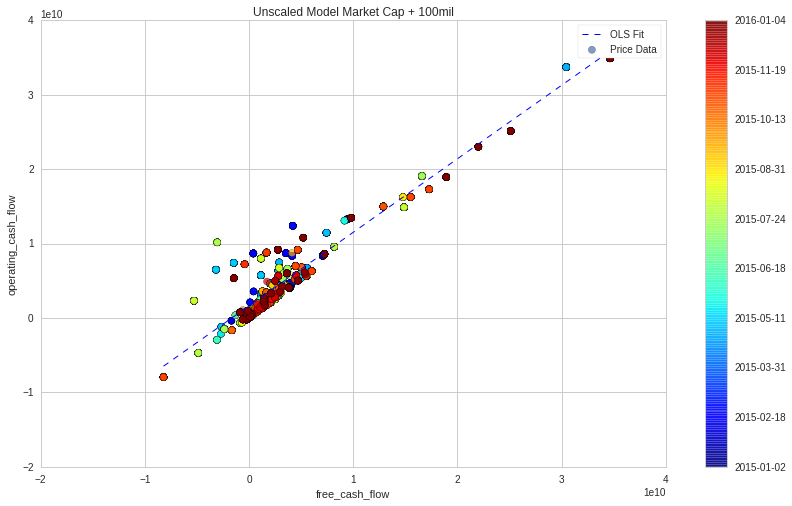

In [72]:
x = df
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(fcf, op_cf, s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('free_cash_flow')
plt.ylabel('operating_cash_flow')
plt.title('Unscaled Model Market Cap + 100mil');

In [73]:
r_b = df['free_cash_flow']
r_a = df['operating_cash_flow']
rev = df['total_revenue']
x = df

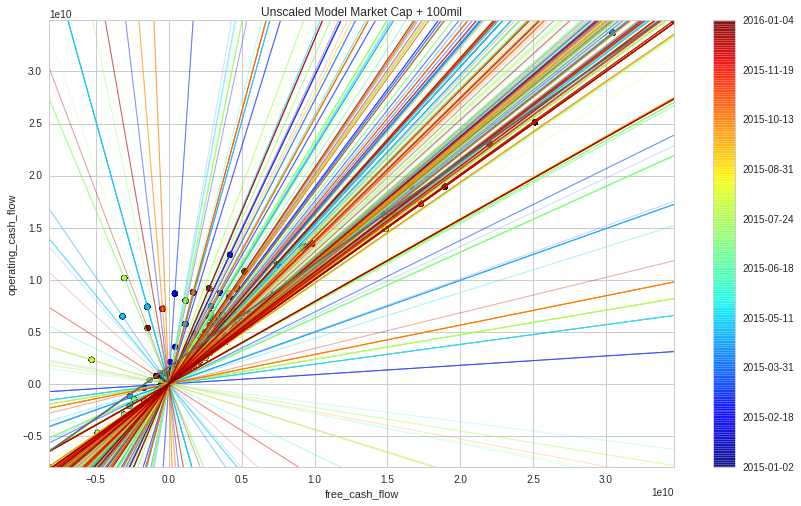

In [74]:
# Get returns from pricing data
x_r = r_b
y_r = r_a

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-8.209000e+09, 3.466000e+10,-7.951000e+09, 3.490200e+10])

# Label axes
plt.xlabel('free_cash_flow')
plt.ylabel('operating_cash_flow')
plt.title('Unscaled Model Market Cap + 100mil');

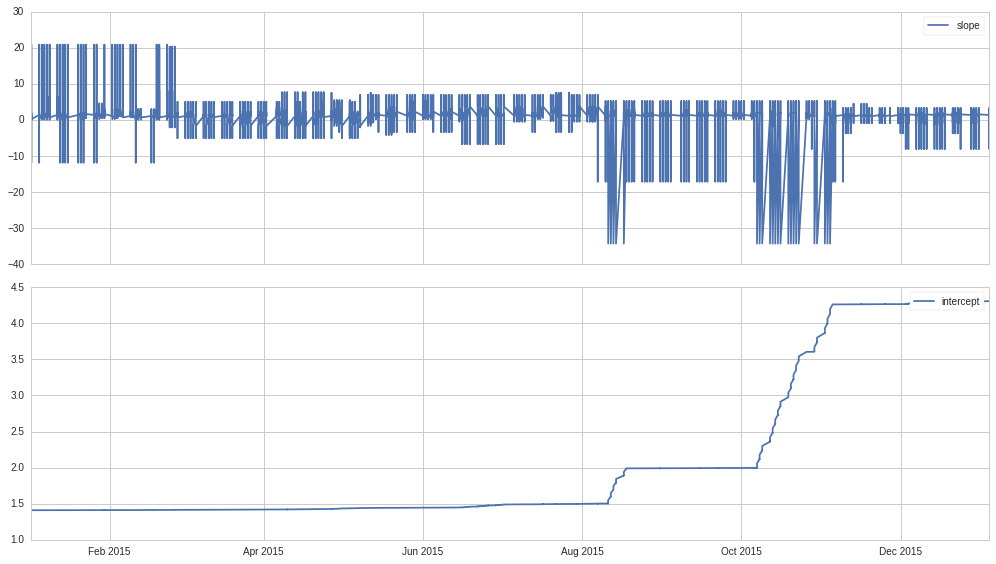

In [75]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means_r[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means_r[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

In [76]:
# Run linear regression with inputs scaled by total revenue
scaled_model = regression.linear_model.OLS(
    data['operating_cash_flow'].values/data['total_revenue'].values,
    sm.add_constant(data['free_cash_flow'].values/data['total_revenue'].values), missing='drop').fit()

prediction = scaled_model.params[0] + scaled_model.params[1]*(data['free_cash_flow'].values/data['total_revenue'].values)

In [77]:
scaled_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.924      
Dependent Variable: y                AIC:                -12274.9754
Date:               2019-04-18 06:36 BIC:                -12261.6521
No. Observations:   5777             Log-Likelihood:     6139.5     
Df Model:           1                F-statistic:        7.005e+04  
Df Residuals:       5775             Prob (F-statistic): 0.00       
R-squared:          0.924            Scale:              0.0069918  
-----------------------------------------------------------------------
           Coef.     Std.Err.       t        P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
const      0.1089      0.0012     88.8575    0.0000    0.1065    0.1113
x1         0.8778      0.0033    264.6692    0.0000    0.8713    0.8843
--------------------------------------------------------------------
Omnibus:              2611.576      Durbin-Watson:         1.782    
Prob(Omnibus):        0.000         Jarque-Bera (JB):      29093.555
Skew:                 1.866         Prob(JB):              0.000    
Kurtosis:             13.341        Condition No.:         3        
====================================================================

"""

In [78]:
sfcf = data['free_cash_flow'].values/data['total_revenue'].values
socf = data['operating_cash_flow'].values/data['total_revenue'].values

In [79]:
sdf = pd.DataFrame({'free_cash_flow/total_revenue': sfcf,
                   'operating_cash_flow/total_revenue': socf })
sdf = sdf.dropna()
sdf.index = df.index

In [80]:
sdf.head()

,free_cash_flow/total_revenue,operating_cash_flow/total_revenue
2015-01-02 00:00:00+00:00,0.223109,0.314555
2015-01-02 00:00:00+00:00,0.424982,0.454495
2015-01-02 00:00:00+00:00,0.088406,0.166833
2015-01-02 00:00:00+00:00,0.646983,0.669337
2015-01-02 00:00:00+00:00,-0.008160,0.096311


In [81]:
s_fcf = sdf['free_cash_flow/total_revenue']
s_op_cf = sdf['operating_cash_flow/total_revenue']

In [82]:
x = sm.add_constant(s_fcf, prepend=False)
ols = sm.OLS(s_op_cf, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [83]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:              OLS                               Adj. R-squared:     0.924      
Dependent Variable: operating_cash_flow/total_revenue AIC:                -12274.9754
Date:               2019-04-18 06:36                  BIC:                -12261.6521
No. Observations:   5777                              Log-Likelihood:     6139.5     
Df Model:           1                                 F-statistic:        7.005e+04  
Df Residuals:       5775                              Prob (F-statistic): 0.00       
R-squared:          0.924                             Scale:              0.0069918  
---------------------------------------------------------------------------------------
                                Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
---------------------------------------------------------------------------------------
free_cash_flow/total_revenue    0.8778     0.0033   264.6692   0.0000   0.8713   0.8843
const                           0.1089     0.0012    88.8575   0.0000   0.1065   0.1113
-------------------------------------------------------------------------------------
Omnibus:                   2611.576            Durbin-Watson:               1.782    
Prob(Omnibus):             0.000               Jarque-Bera (JB):            29093.555
Skew:                      1.866               Prob(JB):                    0.000    
Kurtosis:                  13.341              Condition No.:               3        
=====================================================================================

"""

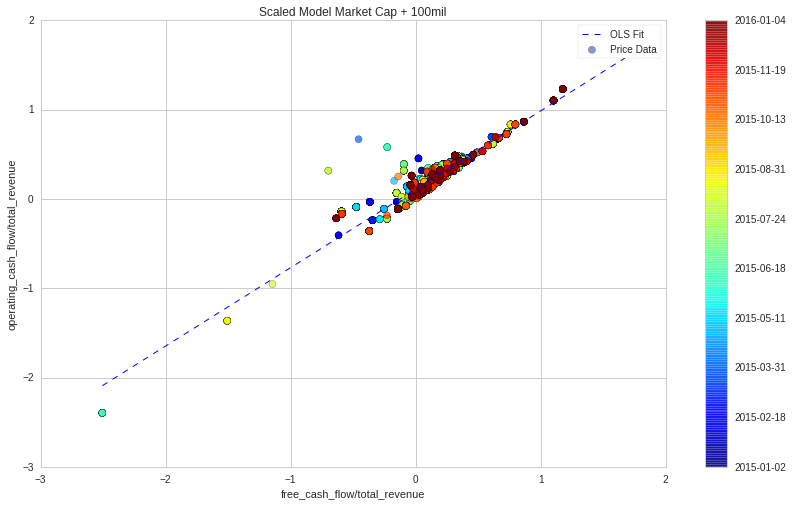

In [84]:
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(s_fcf, s_op_cf, s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('free_cash_flow/total_revenue')
plt.ylabel('operating_cash_flow/total_revenue')
plt.title('Scaled Model Market Cap + 100mil');

In [85]:
r_b = sdf['free_cash_flow/total_revenue']
r_a = sdf['operating_cash_flow/total_revenue']
x = sdf

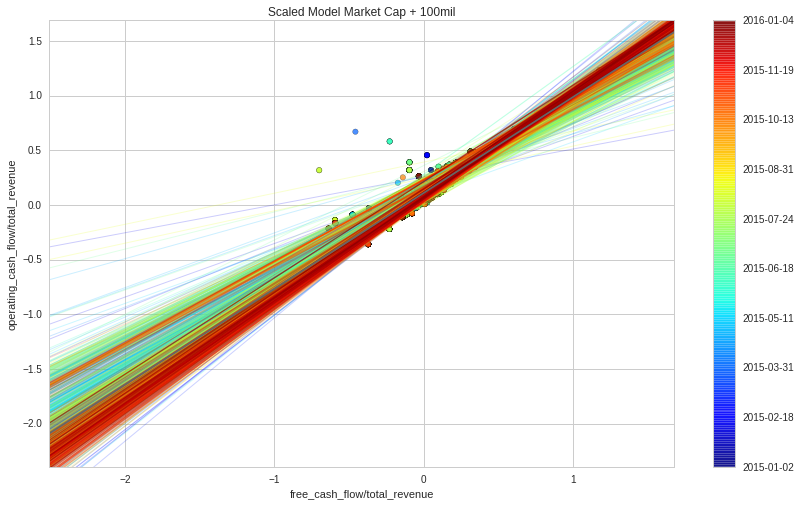

In [86]:
# Get returns from pricing data
x_r = r_b
y_r = r_a

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-2.507037, 1.675853,-2.396038, 1.687554])

# Label axes
plt.xlabel('free_cash_flow/total_revenue')
plt.ylabel('operating_cash_flow/total_revenue')
plt.title('Scaled Model Market Cap + 100mil');

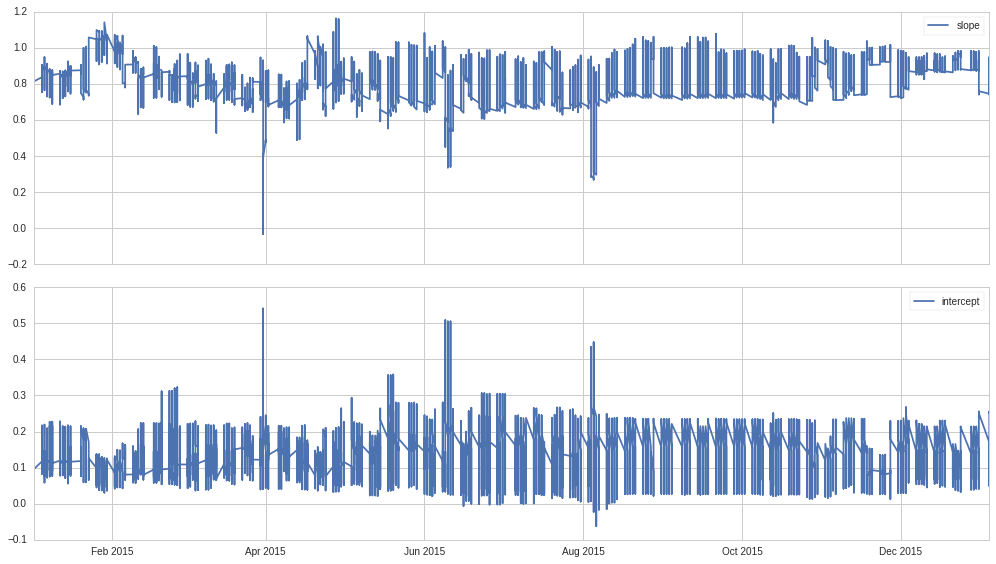

In [87]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means_r[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means_r[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

In [90]:
from sklearn.covariance import LedoitWolf
from sklearn import covariance
import seaborn as sns

In [91]:
lw_cov = LedoitWolf().fit(df).covariance_ # Calculate Ledoit-Wolf Estimator

In [92]:
corr = extract_corr_from_cov(lw_cov)

In [93]:
def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

In [94]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print 'Average pairwise correlation: %.4f' % average_corr

Average pairwise correlation: 0.5709


In [95]:
dates = df.resample('M').first().index
returns = df

In [96]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)

In [97]:
lw_diffs = []
for pair in zip(lw_covs[:-1], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)

In [98]:
data = pd.DataFrame({
        'Ledoit-Wolf Error': lw_diffs})

count    1.100000e+01
mean     1.487176e+20
std      7.933345e+19
min      3.090134e+19
25%      9.327107e+19
50%      1.221820e+20
75%      2.146273e+20
max      2.915941e+20
Name: Ledoit-Wolf Error, dtype: float64


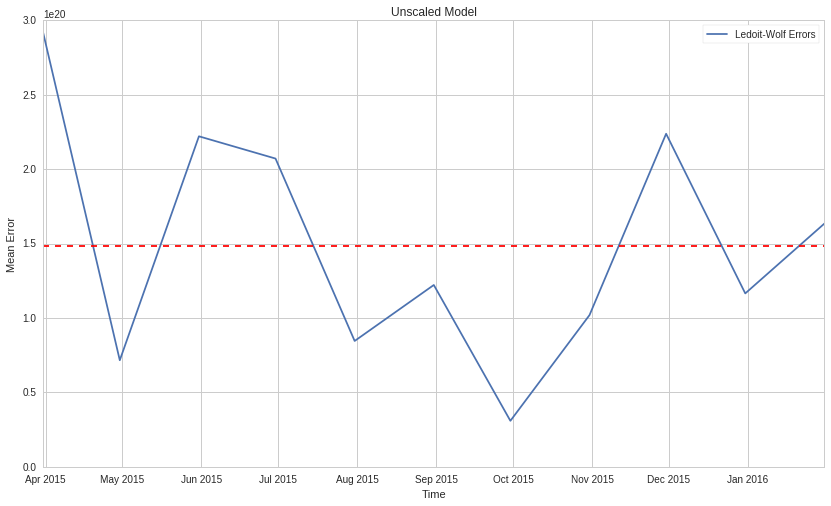

In [99]:
plt.plot(dates[2:], lw_diffs)
plt.axhline(data['Ledoit-Wolf Error'].mean(), linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors']);
plt.title('Unscaled Model');
print data['Ledoit-Wolf Error'].describe()

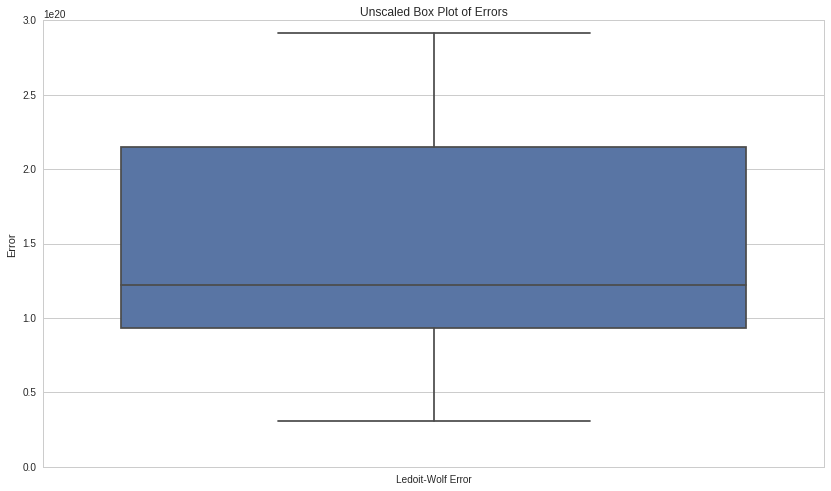

In [100]:
sns.boxplot(
    data = pd.DataFrame({
        'Ledoit-Wolf Error': lw_diffs })
)
plt.title('Unscaled Box Plot of Errors')
plt.ylabel('Error');

In [101]:
lw_covs = LedoitWolf().fit(sdf).covariance_ # Calculate Ledoit-Wolf Estimator

In [102]:
corrs = extract_corr_from_cov(lw_covs)

In [103]:
average_corrs = np.mean(corr[np.triu_indices_from(corrs, k=1)])
print 'Average pairwise correlation scaled model: %.4f' % average_corrs
print 'Average pairwise correlation: %.4f' % average_corr

Average pairwise correlation scaled model: 0.9319
Average pairwise correlation: 0.5709


In [104]:
datess = sdf.resample('M').first().index
returnss = sdf

In [105]:
sample_covss = []
lw_covss = []

for i in range(1, len(datess)):
    sample_covs = returnss[datess[i-1]:datess[i]].cov().values
    sample_covss.append(sample_covs)
    
    lw_covs = covariance.ledoit_wolf(returnss[datess[i-1]:datess[i]])[0]
    lw_covss.append(lw_covs)

In [106]:
lw_diffss = []
for pair in zip(lw_covss[:-1], lw_covss[1:]):
    diffs = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffss.append(diffs)

In [107]:
datas = pd.DataFrame({
        'Scaled Model Ledoit-Wolf Error': lw_diffss})

count    11.000000
mean      0.188045
std       0.206888
min       0.018054
25%       0.031399
50%       0.083481
75%       0.319089
max       0.598090
Name: Scaled Model Ledoit-Wolf Error, dtype: float64


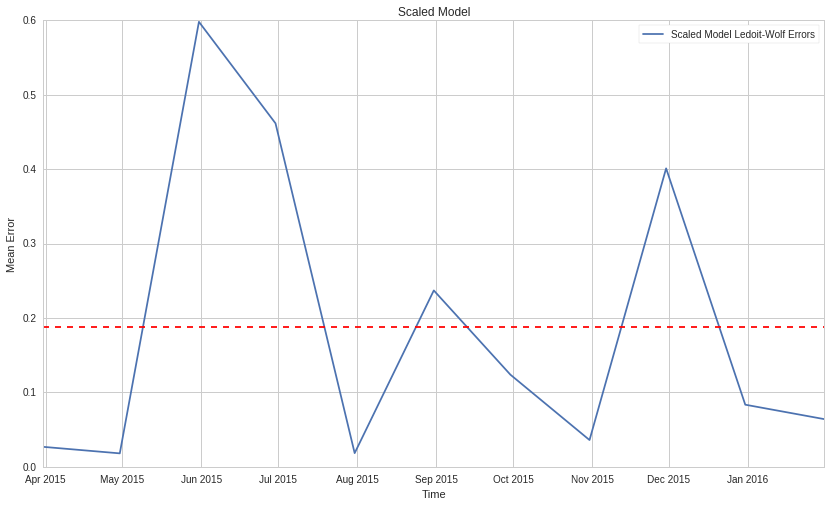

In [108]:
plt.plot(datess[2:], lw_diffss)
plt.axhline(datas['Scaled Model Ledoit-Wolf Error'].mean(), linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Scaled Model Ledoit-Wolf Errors']);
plt.title('Scaled Model');
print datas['Scaled Model Ledoit-Wolf Error'].describe()

count    1.100000e+01
mean     1.487176e+20
std      7.933345e+19
min      3.090134e+19
25%      9.327107e+19
50%      1.221820e+20
75%      2.146273e+20
max      2.915941e+20
Name: Ledoit-Wolf Error, dtype: float64
count    11.000000
mean      0.188045
std       0.206888
min       0.018054
25%       0.031399
50%       0.083481
75%       0.319089
max       0.598090
Name: Scaled Model Ledoit-Wolf Error, dtype: float64


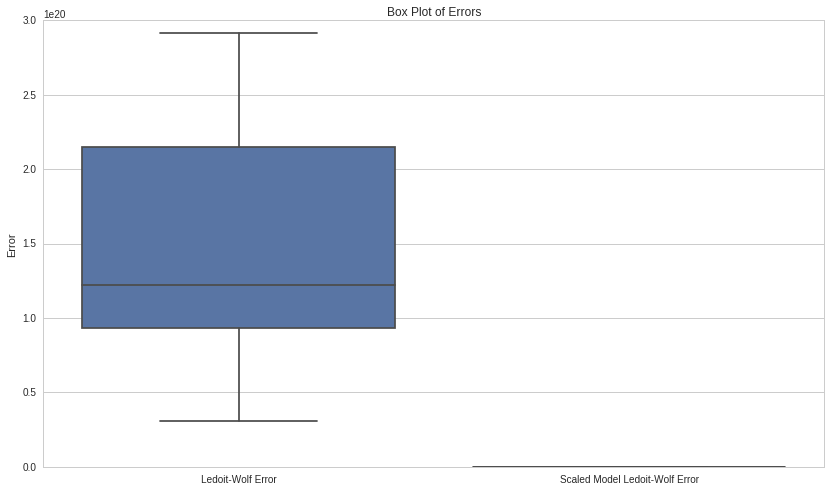

In [109]:
sns.boxplot(
    data = pd.DataFrame({
        'Ledoit-Wolf Error': lw_diffs,
        'Scaled Model Ledoit-Wolf Error': lw_diffss,
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');
print data['Ledoit-Wolf Error'].describe()
print datas['Scaled Model Ledoit-Wolf Error'].describe()